In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aryanshelke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aryanshelke/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Load the datasets
df_true = pd.read_csv('data/True.csv')
df_fake = pd.read_csv('data/Fake.csv')

# Add labels
df_true['label'] = 1
df_fake['label'] = 0

# Drop unnecessary columns and combine datasets
df_true.drop(['subject', 'date'], axis=1, inplace=True)
df_fake.drop(['subject', 'date'], axis=1, inplace=True)

# Combine and shuffle the datasets
df = pd.concat([df_true, df_fake]).sample(frac=1).reset_index(drop=True)
print("Dataset shape:", df.shape)

Dataset shape: (44898, 3)


In [3]:
# Text preprocessing function
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize and remove stopwords
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    return ' '.join(words)

# Apply preprocessing to text column
df['text'] = df['text'].apply(preprocess_text)

# Tokenization parameters
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 200

# Initialize tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(df['text'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['text'])

# Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['label'], 
                                                    test_size=0.2, random_state=42)

# Print shapes to verify
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (35918, 200)
Testing data shape: (8980, 200)


In [6]:
# Model parameters
EMBEDDING_DIM = 100
vocab_size = len(tokenizer.word_index) + 1

# Create the BiLSTM model
BILSTM_model = Sequential([
    # Embedding layer
    Embedding(vocab_size, EMBEDDING_DIM),
    
    # First BiLSTM layer with return sequences
    Bidirectional(LSTM(64, return_sequences=True)),
    
    # Second BiLSTM layer
    Bidirectional(LSTM(32)),
    
    # Dense layers with dropout
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Build the model with explicit input shape
BILSTM_model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))

# Compile the model
BILSTM_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Print model summary
BILSTM_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 200, 100)       │    20,340,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 200, 128)       │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,470,121 (78.09 MB)

 Trainable params: 20,470,121 (78.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 133s 290ms/step - accuracy: 0.9368 - loss: 0.1478 - val_accuracy: 0.9985 - val_loss: 0.0083
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 142s 316ms/step - accuracy: 0.9996 - loss: 0.0036 - val_accuracy: 0.9981 - val_loss: 0.0118
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 161s 358ms/step - accuracy: 0.9993 - loss: 0.0033 - val_accuracy: 0.9986 - val_loss: 0.0108
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 169s 377ms/step - accuracy: 1.0000 - loss: 5.5097e-04 - val_accuracy: 0.9986 - val_loss: 0.0121
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 155s 345ms/step - accuracy: 0.9999 - loss: 6.5949e-04 - val_accuracy: 0.9985 - val_loss: 0.0125
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 168s 374ms/step - accuracy: 0.9999 - loss: 7.4141e-04 - val_accuracy: 0.9986 - val_loss: 0.0128
Epoch 7/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 182s 405ms/step - accuracy: 0.9999 - loss: 0.0012 - val_accuracy: 0.9968 - val_loss: 0.0215
Epoch 8/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 169s 377ms/step - accura

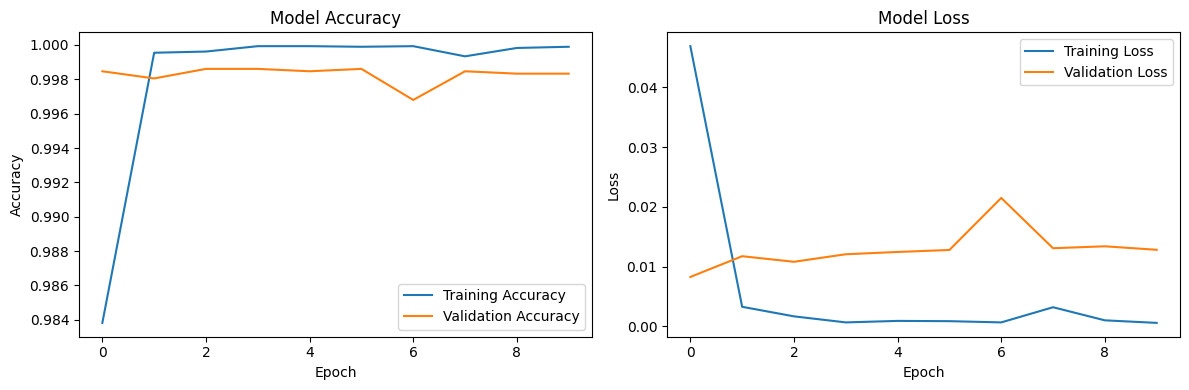

281/281 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.9973 - loss: 0.0149

Test Accuracy: 0.9972


In [7]:
# Training parameters
EPOCHS = 10
BATCH_SIZE = 64

# Train the model
history = BILSTM_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,  # Use 20% of training data for validation
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test set
test_loss, test_accuracy = BILSTM_model.evaluate(X_test, y_test)
print(f'\nTest Accuracy: {test_accuracy:.4f}')

In [8]:
import pickle

# Save the model
with open('models/bilstm_model.pkl', 'wb') as f:
    pickle.dump(BILSTM_model, f)

# Save the tokenizer
with open('models/bilstm_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)